# Offline Phase: generation of the reduced basis and placing the sensors
This notebook used the snapshots and generates the reduced basis using the POD algorithm, the magic functions and sensors with GEIM and the sensors for the update space using SGREEDY.


Let us generate the mesh and make a plot of it

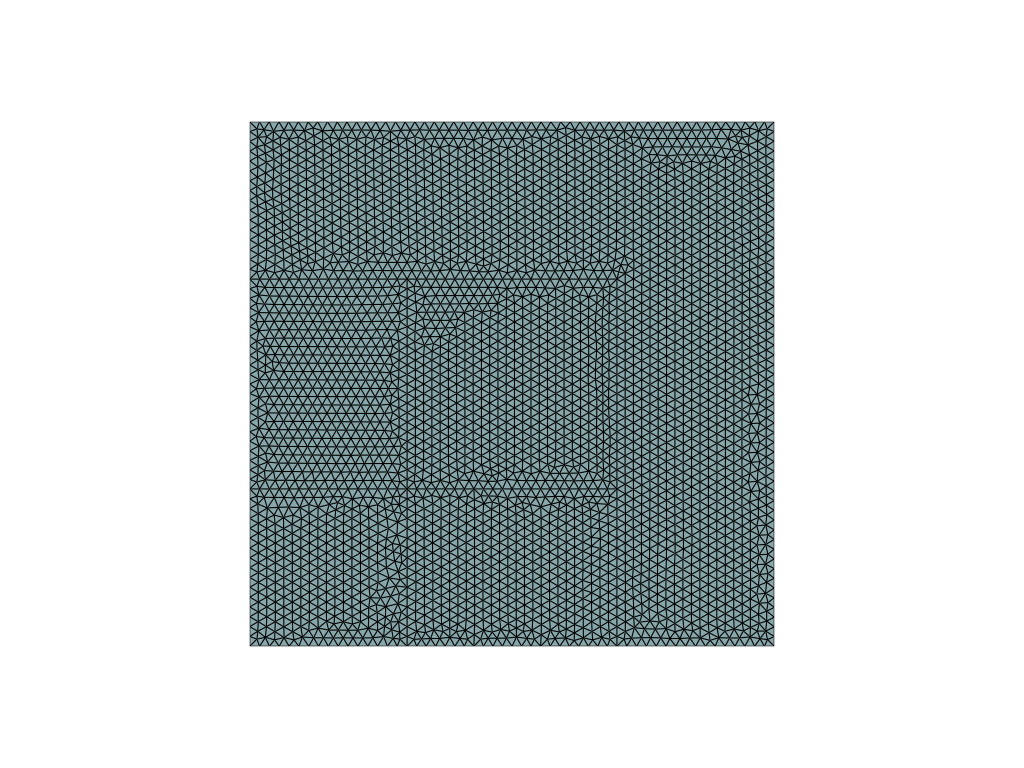

In [1]:
from dolfinx.io import gmshio
from mpi4py import MPI
import pyvista as pv
from IPython.display import clear_output as clc

gdim = 2

domain, ct, ft = gmshio.read_from_msh("TWIGL2D.msh", MPI.COMM_WORLD, gdim = gdim)
clc()

# Plot the mesh
from dolfinx.plot import create_vtk_mesh
grid = pv.UnstructuredGrid(*create_vtk_mesh(domain))
pl = pv.Plotter()
pl.add_mesh(grid, show_edges=True, color="lightblue", line_width=1.0)
pl.view_xy()
pl.show(jupyter_backend='static')

Let us load the snapshots

In [2]:
from pyforce.tools.write_read import ImportH5
import numpy as np
from sklearn.model_selection import train_test_split
from pyforce.tools.functions_list import FunctionsList
from dolfinx.fem import FunctionSpace
from pyforce.tools.backends import LoopProgress

D1_parameters = np.linspace(0.5, 2, 25) # parameter space
var_names = ['phi_1', 'phi_2', 'T']

path_snaps = '../../../Data/TWIGL2D/iFOM/'

# Generate functional space
fun_space = {
    field: FunctionSpace(domain, ("CG", 1)) for field in var_names
}

train_idx, _, train_params, _ = train_test_split(   np.arange(1, len(D1_parameters)+1), 
                                                    D1_parameters, 
                                                    test_size=0.25, random_state=20)

train_idx = np.sort(train_idx)

train_snaps = dict()

for field in var_names:
    train_snaps[field] = FunctionsList(function_space=fun_space[field])

    bar = LoopProgress(msg=f"Loading {field} snapshots", final=len(train_idx))

    for idx in train_idx:

        _tmp_snap, fom_times = ImportH5(fun_space[field], 
                                        path_snaps + f"D1_{idx}/{field}",
                                        field)
        for snap in _tmp_snap._list:
            train_snaps[field].append(snap)
        bar.update(1)

fom_times = np.asarray(fom_times)

  ufl_element = basix.ufl_wrapper.create_element(



Loading phi_1 snapshots: 18.000 / 18.00 - 0.005 s/it
Loading phi_2 snapshots: 18.000 / 18.00 - 0.006 s/it
Loading T snapshots: 18.000 / 18.00 - 0.005 s/it


## Proper Orthogonal Decomposition (POD)
This section generates the reduced basis using the POD algorithm.

In [3]:
from pyforce.offline.pod import POD

pod_offline = dict()
for field in var_names:
    pod_offline[field] = POD(train_snaps[field], field, verbose=True)

Computing phi_1 correlation matrix: 918.000 / 918.00 - 0.043 s/it
Computing phi_2 correlation matrix: 918.000 / 918.00 - 0.044 s/it
Computing T correlation matrix: 918.000 / 918.00 - 0.044 s/it


Let us plot the singular values of the snapshots

Text(0, 0.5, 'Residual energy')

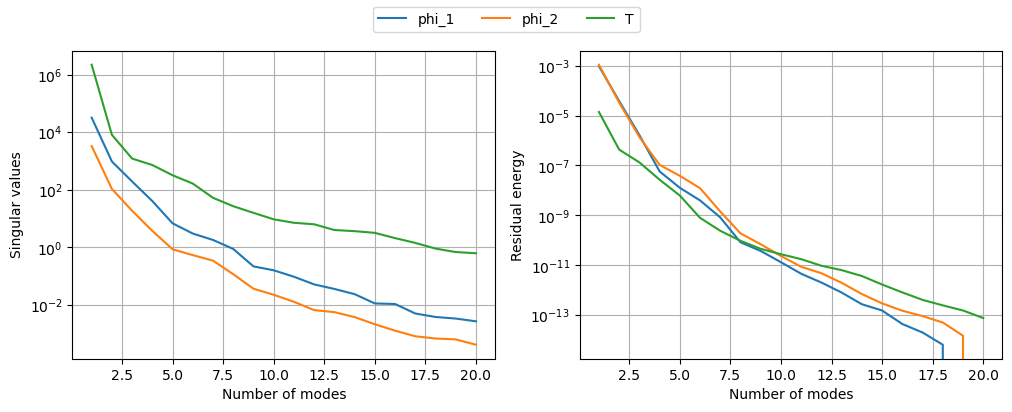

In [6]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(12, 4))

Nplot=np.arange(1, 21)
for field in var_names:
    axs[0].semilogy(Nplot, np.sqrt(pod_offline[field].eigenvalues[:max(Nplot)]), label=field)
    axs[1].semilogy(Nplot, 1 - np.cumsum(pod_offline[field].eigenvalues)[:max(Nplot)]/np.sum(pod_offline[field].eigenvalues), label=field)

Lines, Labels = axs[0].get_legend_handles_labels()
fig.legend(Lines, Labels, loc='upper center', ncols=4)

for ax in axs:
    ax.set_xlabel('Number of modes')
    ax.grid()
axs[0].set_ylabel('Singular values')
axs[1].set_ylabel('Residual energy')

Let us compute the reduced basis using the POD algorithm

In [7]:
from pyforce.tools.write_read import StoreFunctionsList
import os

path_offline = 'Results/POD_offline/'
os.makedirs(path_offline, exist_ok=True)

rank = 5

for field in var_names:
    pod_offline[field].compute_basis(train_snaps[field], maxBasis=rank)
    StoreFunctionsList(domain, pod_offline[field].PODmodes, f'POD_modes_{field}', 
                       path_offline+f'POD_modes_{field}')

Let us plot the reduced space

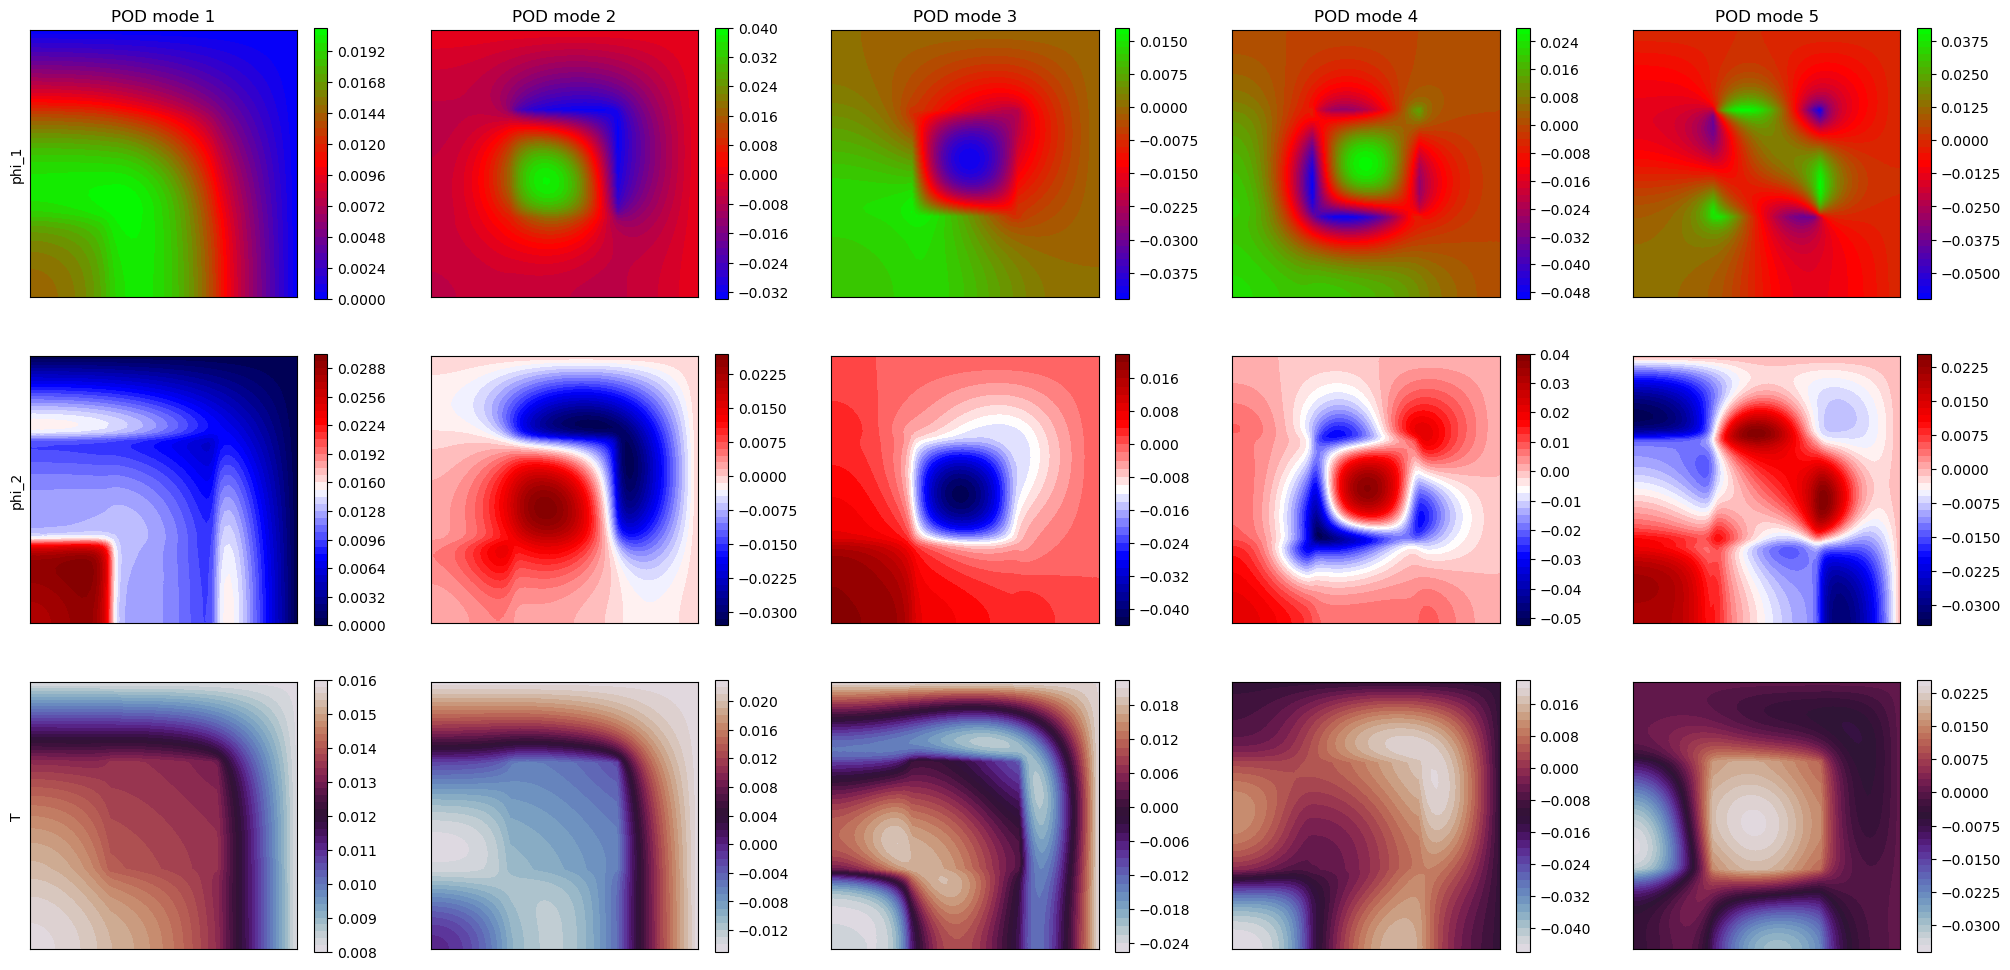

In [70]:
from utils import plot_contour
from matplotlib import cm

cmaps = [cm.brg, cm.seismic, cm.twilight]

fig, axs = plt.subplots(len(var_names), rank, figsize=(5 * rank, 4 * len(var_names)))

for ii, field in enumerate(var_names):
    for rr in range(rank):
        cont = plot_contour(axs[ii, rr], domain.geometry.x, pod_offline[field].PODmodes(rr),
                     cmap=cmaps[ii], levels=40)
        fig.colorbar(cont, ax=axs[ii, rr])

        if rr == 0:
            axs[ii, rr].set_ylabel(f'{field}')
        
        axs[0, rr].set_title(f'POD mode {rr+1}')


## Generalized Empirical Interpolation Method (GEIM)
This section generates the magic functions and sensors using the GEIM algorithm.

In [79]:
from pyforce.offline.geim import GEIM

geim_offline = dict()

Mmax = 25
sam_every = 10
beta_coeff = dict()

for field in var_names:
    geim_offline[field] = GEIM(domain, fun_space[field], field, s=1)
    _, _, beta_coeff[field] = geim_offline[field].offline(  train_snaps[field], Mmax,
                                                            sampleEvery = sam_every, verbose = True)

clc()

Let us store the magic functions and sensors

In [81]:
path_offline = 'Results/GEIM_offline/'
os.makedirs(path_offline, exist_ok=True)

for field in var_names:
    StoreFunctionsList(domain, geim_offline[field].magic_fun, f'GEIM_{field}_mf',
                        filename = path_offline+f'GEIM_{field}_mf')
    StoreFunctionsList(domain, geim_offline[field].magic_sens, f'GEIM_{field}_ms',
                        filename = path_offline+f'GEIM_{field}_ms')

    np.savez_compressed(path_offline+f'GEIM_{field}_TrainBeta.npz',
                        beta=beta_coeff[field])

Let us plot the magic functions

[Text(0.5, 1.0, 'Magic Function 1'),
 Text(0.5, 1.0, 'Magic Function 2'),
 Text(0.5, 1.0, 'Magic Function 3'),
 Text(0.5, 1.0, 'Magic Function 4'),
 Text(0.5, 1.0, 'Magic Function 5')]

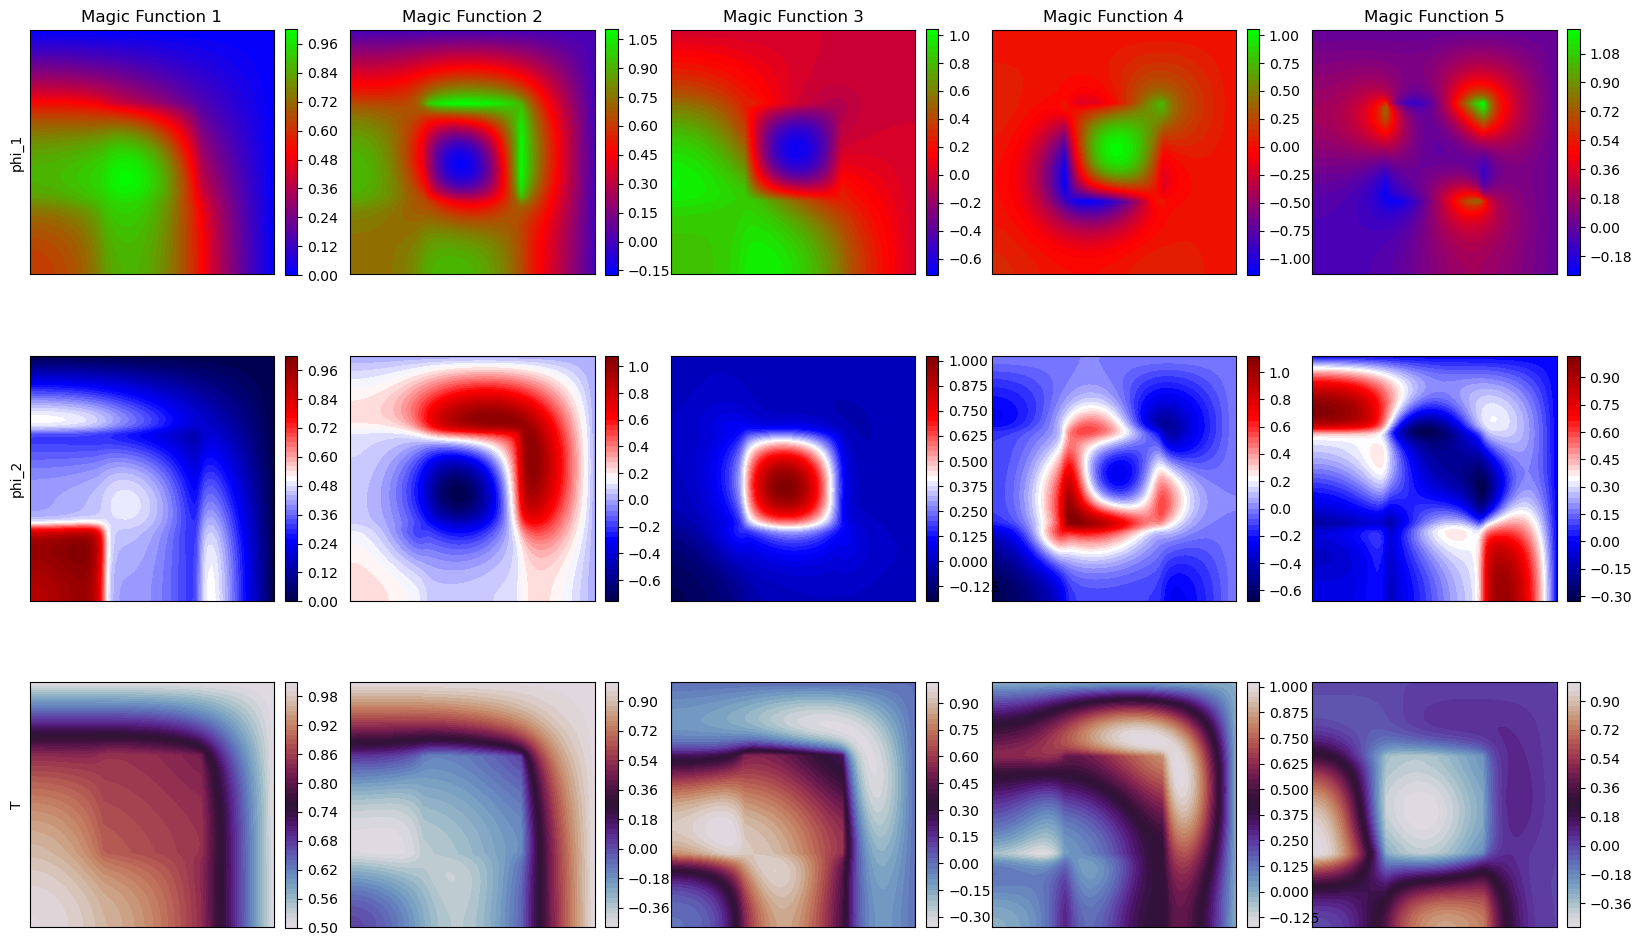

In [ ]:
mf_to_plot = np.arange(0, 5, 1)

nrows = len(var_names)
ncols = len(mf_to_plot)

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

for row, field in enumerate(var_names):
    for col in range(ncols):
        mf = geim_offline[field].magic_fun(mf_to_plot[col])
        cont = plot_contour(axs[row, col], domain.geometry.x, mf, levels=50, cmap=cmaps[row])
        cbar = fig.colorbar(cont, ax=axs[row, col], fraction=0.046, pad=0.04)
    axs[row, 0].set_ylabel(field)

[axs[0, col].set_title(f'Magic Function {mf_to_plot[col]+1}') for col in range(ncols)]

Let us plot the magic sensors

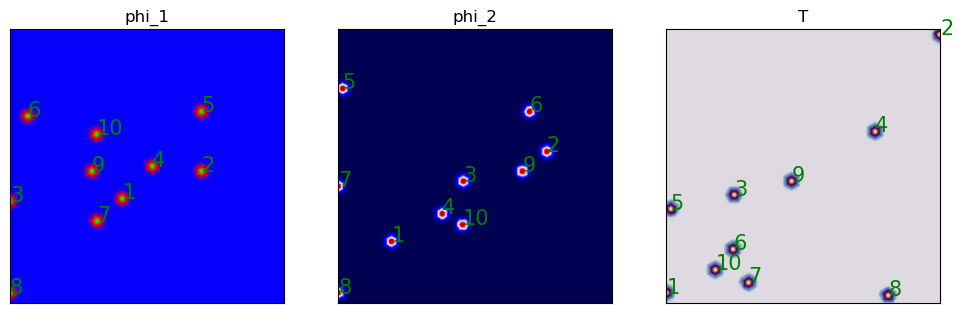

In [91]:
sens_to_plot = 10

fig, axs = plt.subplots(1, len(var_names), figsize=(len(var_names)*4, 4))

for col, field in enumerate(var_names):
    ms = np.zeros((train_snaps[field].fun_shape,))

    locs = list()

    for mm in range(sens_to_plot):
        ms += geim_offline[field].magic_sens(mm) / max(geim_offline[field].magic_sens(mm))
        locs.append(np.argmax(geim_offline[field].magic_sens(mm)))
    points = domain.geometry.x[locs, :2]
    labels = [str(mm+1) for mm in range(sens_to_plot)]
    cont = plot_contour(axs[col], domain.geometry.x[:, :2], ms, levels=50, cmap=cmaps[col])
    axs[col].set_title(field)

    offset = 0.01
    for (x, y), label in zip(points, labels):
        axs[col].text(x + offset, y + offset, label, fontsize=15, color='green')


## SGREEDY
This section generates the sensors for the update space using the SGREEDY algorithm, using the POD basis to compute the set of sensors.

In [94]:
from pyforce.offline.sensors import SGREEDY

s = 1.
sgreedy_pod = dict()

for field_i, field in enumerate(var_names):
    sgreedy_pod[field] = SGREEDY(domain, pod_offline[field].PODmodes, fun_space[field], field, s)
    sgreedy_pod[field].generate(rank, Mmax, tol=0.5, sampleEvery=sam_every, verbose=True, is_H1=True)


Generating sensors (sampled every 10 cells): 360.000 / 360.00 - 0.001 s/it
m = 25, n = 05 | beta_n,m = 0.366922
Generating sensors (sampled every 10 cells): 360.000 / 360.00 - 0.001 s/it
m = 25, n = 05 | beta_n,m = 0.377214
Generating sensors (sampled every 10 cells): 360.000 / 360.00 - 0.001 s/it
m = 25, n = 05 | beta_n,m = 0.284398


Let us plot the selected sensors

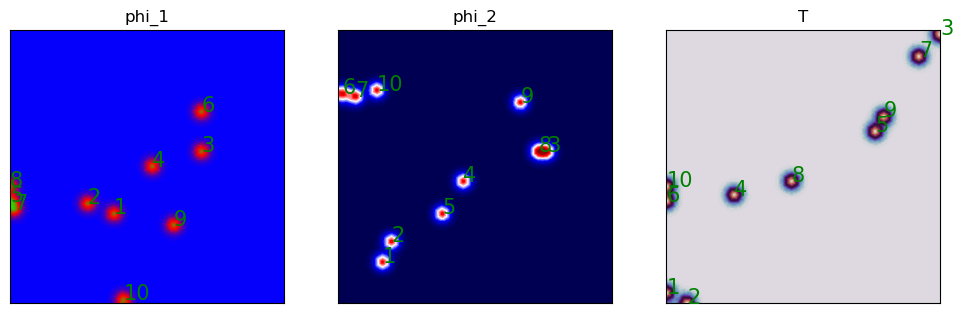

In [ ]:
sens_to_plot = 10

fig, axs = plt.subplots(1, len(var_names), figsize=(len(var_names)*4, 4))

for col, field in enumerate(var_names):
    ms = np.zeros((train_snaps[field].fun_shape,))

    locs = list()

    for mm in range(sens_to_plot):
        ms += sgreedy_pod[field].basis_sens(mm) / max(sgreedy_pod[field].basis_sens(mm))
        locs.append(np.argmax(sgreedy_pod[field].basis_sens(mm)))
    points = domain.geometry.x[locs, :2]
    labels = [str(mm+1) for mm in range(sens_to_plot)]
    cont = plot_contour(axs[col], domain.geometry.x[:, :2], ms, levels=50, cmap=cmaps[col])
    axs[col].set_title(field)

    offset = 0.01
    for (x, y), label in zip(points, labels):
        axs[col].text(x + offset, y + offset, label, fontsize=15, color='green')

Let us store the basis sensors

In [97]:
path_offline = 'Results/SGREEDY_offline/'
os.makedirs(path_offline, exist_ok=True)

for field in var_names:
    StoreFunctionsList(domain, sgreedy_pod[field].basis_sens, f'SGREEDY_{field}_sens',
                        filename = path_offline+f'SGREEDY_{field}_sens')